## Introduction

### Project Description

You are an analyst at Megaline, a federal mobile operator. Clients are offered two tariff plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department wants to understand which tariff brings in more money. You have to make a preliminary analysis of tariffs on a small sample of customers. At your disposal are the data of 500 Megaline users: who they are, where they are from, what tariff they use, how many calls and messages each sent in 2018. It is necessary to analyze the behavior of customers and draw a conclusion - which tariff is better.

<b>Description of tariffs:</b>

- <b>Tariff "Smart"</b><br>
    Monthly fee: 550 rubles<br>
    Includes 500 minutes of calls, 50 messages and 15 GB of internet traffic<br>
    The cost of services above the tariff package:<br>
    - minute of conversation: 3 rubles<br>
    - message: 3 rubles<br>
    - 1 GB of Internet traffic: 200 rubles<br>
<br>
- <b>Tariff "Ultra"</b><br>
    Monthly fee: 1950 rubles<br>
    Includes 3,000 minutes of calls, 1,000 messages and 30 GB of internet traffic<br>
    The cost of services above the tariff package:<br>
    - minute of conversation: 1 ruble<br>
    - message: 1 ruble<br>
    - 1 GB of Internet traffic: 150 rubles<br>

### Data Description
- Table <font size = 4><b>`users`</b></font> (user information):
    - `user_id` - unique user ID
    - `first_name` — username
    - `last_name` — user last name
    - `age` — user age (years)
    - `reg_date` — tariff connection date (day, month, year)
    - `churn_date` — date when the tariff was terminated (if the value is omitted, then the tariff was still valid at the time of data upload)
    - `city` — user's city of residence
    - `tarif` — tariff plan name
<br>
<br>
- Table <font size = 4><b>`calls`</b></font> (call information):
    - `id` — unique call number
    - `call_date` — call date
    - `duration` — call duration in minutes
    - `user_id` — identifier of the user who made the call
<br>
<br>
- Table <font size = 4><b>`messages`</b></font> (message information):
    - `id` — unique message number
    - `message_date` — message date
    - `user_id` - ID of the user who sent the message
<br>
<br>
- Table <font size = 4><b>`internet`</b></font> (information about internet sessions):
    - `id` — unique session number
    - `mb_used` — amount of Internet traffic spent per session (in megabytes)
    - `session_date` — internet session date
    - `user_id` - user ID
<br>
<br>
- Table <font size = 4><b>`tariffs`</b></font> (information about tariffs):
    - `tariff_name` — tariff name
    - `rub_monthly_fee` — monthly subscription fee in rubles
    - `minutes_included` - the number of minutes of conversation per month included in the subscription fee
    - `messages_included` - the number of messages per month included in the subscription fee
    - `mb_per_month_included` - the amount of Internet traffic included in the subscription fee (in megabytes)
    - `rub_per_minute` - the cost of a minute of conversation in excess of the tariff package (for example, if the tariff includes 100 minutes of conversation per month, then a fee will be charged from 101 minutes)
    - `rub_per_message` - the cost of sending a message in excess of the tariff package
    - `rub_per_gb` - the cost of an additional gigabyte of Internet traffic in excess of the tariff package (1 gigabyte = 1024 megabytes)

### Introduction to dataset

In [1]:
#import the necessary libraries
import pandas as pd
import numpy as np
from scipy import stats as st
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#read and save data from files
calls = pd.read_csv('/datasets/calls.csv') #call information
internet = pd.read_csv('/datasets/internet.csv') #information about internet sessions
messages = pd.read_csv('/datasets/messages.csv') #message information
tariffs = pd.read_csv('/datasets/tariffs.csv') #information about tariffs
users = pd.read_csv('/datasets/users.csv') #user information

<font size = 3><b>Dataset with information about calls</b></font>

In [3]:
calls.sample(10)

,id,call_date,duration,user_id
165470,1409_95,2018-12-30,0.00,1409
34429,1085_132,2018-08-21,12.53,1085
66422,1168_1573,2018-04-14,9.29,1168
177671,1439_218,2018-11-28,9.51,1439
195897,1480_208,2018-07-21,5.05,1480
22364,1057_813,2018-09-30,10.91,1057
34342,1085_45,2018-12-12,11.02,1085
57169,1145_0,2018-10-18,0.00,1145
110898,1284_496,2018-08-29,1.56,1284
118534,1307_8,2018-05-31,9.74,1307


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
print('Number of duplicates:', calls.duplicated().sum())

Number of duplicates: 0


- This dataset has 4 columns and 202,607 rows.
- There are no passes.
- There are no duplicates.
- There are no problems with column names.
- It is necessary to cast the column with the date of the call to the datetime type.
- Leave zero values in the call duration column as they are, these are missed calls.
- The data in the `duration` column will be rounded up to the nearest integer and the format will be changed to int32.

<font size = 3><b>Dataset with information about Internet sessions</b></font>

In [6]:
internet.sample(10)

,Unnamed: 0,id,mb_used,session_date,user_id
10329,10329,1035_164,724.93,2018-10-21,1035
52094,52094,1176_249,255.86,2018-05-17,1176
147076,147076,1492_26,752.10,2018-10-04,1492
17635,17635,1061_24,225.00,2018-11-23,1061
89618,89618,1302_418,625.39,2018-06-20,1302
41616,41616,1145_352,1073.89,2018-05-28,1145
113059,113059,1382_52,330.69,2018-04-24,1382
104940,104940,1355_152,0.00,2018-09-12,1355
32767,32767,1114_164,1026.84,2018-12-04,1114
136286,136286,1457_128,822.65,2018-10-12,1457


In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [8]:
print('Number of duplicates:', internet.duplicated().sum())

Number of duplicates: 0


- This dataset has 5 columns and 149,396 rows.
- There are no passes.
- There are no duplicates.
- There are no problems with column names.
- The `Unnamed` column duplicates the indexes, so it can be removed.
- You need to convert the date column to the datetime type.
- The data in the Internet traffic column will be rounded to whole numbers.
- Add a column with traffic rounded to Gigabytes.

<font size = 3><b>Dataset with information about messages</b></font>

In [9]:
messages.sample(10)

,id,message_date,user_id
28353,1122_176,2018-12-10,1122
96015,1395_2,2018-11-11,1395
5747,1023_92,2018-12-18,1023
602,1003_36,2018-11-11,1003
64547,1277_1224,2018-03-10,1277
543,1002_47,2018-10-18,1002
101163,1414_107,2018-12-21,1414
112547,1453_572,2018-10-09,1453
81114,1340_88,2018-07-18,1340
111820,1452_209,2018-09-25,1452


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
print('Number of duplicates:', messages.duplicated().sum())

Number of duplicates: 0


- This dataset has 3 columns and 123,036 rows.
- There are no passes.
- There are no duplicates.
- There are no problems with column names.
- You need to convert the date column to the datetime type.

<font size = 3><b>Dataset with information about tariffs</b></font>

In [12]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [13]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


- This dataset has 8 columns and only 2 rows with two different tariffs.
- There are no passes.
- There are no problems with column names.
- All columns of the desired type.

<font size = 3><b>Dataset with information about users</b></font>

In [14]:
users.sample(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
207,1207,57,NaN,Балашиха,Яна,Зеленина,2018-08-12,smart
446,1446,64,NaN,Липецк,Антонина,Артемчук,2018-08-31,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
374,1374,67,NaN,Махачкала,Леонид,Аркадьев,2018-04-01,smart
298,1298,29,NaN,Новосибирск,Надежда,Чеснокова,2018-07-26,smart
459,1459,31,NaN,Магнитогорск,Леон,Ёрохов,2018-10-10,smart
474,1474,66,NaN,Набережные Челны,Олег,Любимов,2018-11-11,ultra
219,1219,75,NaN,Киров,Кузьма,Некрасов,2018-01-21,smart
480,1480,29,2018-09-26,Новокузнецк,Гелена,Емельянова,2018-02-14,smart
76,1076,40,NaN,Уфа,Фёдор,Шарапов,2018-03-10,smart


In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [16]:
print('Number of duplicates:', users.duplicated().sum())

Number of duplicates: 0


- This dataset has 8 columns and 500 rows.
- There are gaps in the `churn_date` column, but this is normal, because omission means that the tariff was valid at the time of uploading the data. Let's cast this column to the datetime type.
- There are no duplicates.
- There are no problems with column names.
- You need to convert the date column to the datetime type.

### Section Conclusion

- All datasets are loaded and studied.
- No gaps or obvious duplicates found.
- Defined goals for preprocessing and changing data types.
<br>
<br>
<br>

## Data preparation

<b>At this stage</b>:
1. Let's bring the data to the required types. We will find and correct errors in the data, if any.
2. Let's calculate for each user:
    - the number of calls made and spent minutes of conversation by month;
    - the number of sent messages by month;
    - the amount of Internet traffic used by months;
    - monthly revenue from each user.

### Data preprocessing

<font size = 3><b>Let's cast data in columns with dates to the datetime type.</b></font>

In [17]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format ='%Y-%m-%d')

In [18]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format ='%Y-%m-%d')

In [19]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format ='%Y-%m-%d')

In [20]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format ='%Y-%m-%d')

In [21]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format ='%Y-%m-%d')

<font size = 3><b>Let's add month columns to datasets with calls, messages, and internet sessions.</b></font>

Let's add a column with the year to the largest dataset to find out for how many years the data was uploaded.

In [22]:
calls['year'] = calls['call_date'].dt.year

In [23]:
calls['year'].unique()

array([2018], dtype=int64)

As you can see, only one year is represented here, so you can only add a column with months.

In [24]:
calls.drop(['year'], axis = 1)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


Let's add columns with the month to the datasets with calls, messages and Internet sessions, because we will be analyzing usage data by month.

In [25]:
calls['month'] = calls['call_date'].dt.month

In [26]:
internet['month'] = internet['session_date'].dt.month

In [27]:
messages['month'] = messages['message_date'].dt.month

<font size = 3><b>Let's round the data in the columns with minutes and Internet traffic.</b></font>

In [28]:
np.ceil(calls['duration']).astype('int32')

0          0
1          0
2          3
3         14
4          6
          ..
202602     1
202603    19
202604    11
202605     5
202606    20
Name: duration, Length: 202607, dtype: int32

In [29]:
np.ceil(internet['mb_used']).astype('int32')

0          113
1         1053
2         1198
3          551
4          303
          ... 
149391     319
149392     491
149393       0
149394    1247
149395     545
Name: mb_used, Length: 149396, dtype: int32

<font size = 3><b>Let's remove the `Unnamed` column from the dataset with Internet traffic.</b></font>

In [30]:
internet.drop(['Unnamed: 0'], axis = 1, inplace=True)

<font size = 3><b>Let's group the data for their subsequent merging into one dataset.</b></font><br>

In [31]:
calls_df = (
    calls.groupby(['user_id', 'month'], as_index=False)
    .agg({'duration':['sum', 'count']})
    .astype('int32')
)

In [32]:
#rename columns
calls_df.columns=['user_id', 'month', 'call_duration', 'call_count']

In [33]:
internet_df = internet.groupby(['user_id', 'month'], as_index=False).agg({'mb_used':'sum'})

In [34]:
messages_df = (
    messages.groupby(['user_id', 'month'], as_index=False)
    .agg({'id':'count'})
    .rename(columns={'id':'total_messages'})
    .astype('int32')
)

<font size = 3><b>Let's add columns with used gigabytes.</b></font><br>
To do this, we divide the data from the column with used megabytes by 1024 and round up to an integer.

In [35]:
#first in dataset with internet traffic
internet_df['gb_used'] = internet_df['mb_used'] / 1024
np.ceil(internet_df['gb_used']).astype('int32')

0        3
1       23
2       14
3       14
4       15
        ..
3198    21
3199     2
3200    18
3201    18
3202    13
Name: gb_used, Length: 3203, dtype: int32

In [36]:
#and in the dataset with information about the tariff
tariffs['gb_included'] = tariffs['mb_per_month_included']/1024

<font size = 3><b>Combine all data into one dataset.</b></font><br>

To add a dataset with tariffs, you need to rename the `tariff_name` column to `tariff` in it so that the merge is successful.

In [37]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

In [38]:
df = (
    internet_df.merge(messages_df, on =['user_id', 'month'], how='outer')
    .merge(calls_df, on =['user_id', 'month'], how='outer')
    .merge(users, on =['user_id'], how='left')
    .merge(tariffs, on =['tariff'],how='left')
)

Let's remove columns from the new dataset that we will not use in the analysis.

In [39]:
df.shape

(3214, 22)

In [40]:
df.user_id.nunique()

498

In [41]:
df.drop(['first_name','last_name', 'reg_date', 'mb_per_month_included', 'churn_date', 'mb_used'], axis = 1, inplace=True)

In [42]:
df.sample(10)

,user_id,month,gb_used,total_messages,call_duration,call_count,age,city,tariff,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_included
2412,1380,11,31.913867,27.0,562.0,94.0,45,Ростов-на-Дону,ultra,1000,3000,1950,150,1,1,30.0
2701,1423,5,16.493408,47.0,122.0,23.0,50,Астрахань,smart,50,500,550,200,3,3,15.0
2157,1340,11,15.463506,9.0,508.0,69.0,50,Пенза,smart,50,500,550,200,3,3,15.0
1083,1171,11,15.909043,78.0,673.0,93.0,47,Москва,smart,50,500,550,200,3,3,15.0
291,1046,12,21.327646,48.0,523.0,81.0,72,Тула,smart,50,500,550,200,3,3,15.0
468,1073,10,16.454004,34.0,434.0,70.0,63,Владикавказ,smart,50,500,550,200,3,3,15.0
452,1071,4,16.090557,16.0,307.0,36.0,20,Омск,smart,50,500,550,200,3,3,15.0
3135,1487,12,11.763428,20.0,140.0,30.0,72,Кострома,smart,50,500,550,200,3,3,15.0
299,1048,12,7.985576,78.0,648.0,97.0,73,Новокузнецк,ultra,1000,3000,1950,150,1,1,30.0
1887,1299,3,21.136797,38.0,677.0,82.0,37,Уфа,smart,50,500,550,200,3,3,15.0


Let's check the new dataset for gaps and duplicates.

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            3214 non-null   int64  
 1   month              3214 non-null   int64  
 2   gb_used            3203 non-null   float64
 3   total_messages     2717 non-null   float64
 4   call_duration      3174 non-null   float64
 5   call_count         3174 non-null   float64
 6   age                3214 non-null   int64  
 7   city               3214 non-null   object 
 8   tariff             3214 non-null   object 
 9   messages_included  3214 non-null   int64  
 10  minutes_included   3214 non-null   int64  
 11  rub_monthly_fee    3214 non-null   int64  
 12  rub_per_gb         3214 non-null   int64  
 13  rub_per_message    3214 non-null   int64  
 14  rub_per_minute     3214 non-null   int64  
 15  gb_included        3214 non-null   float64
dtypes: float64(5), int64(9),

In [44]:
print ('Number of duplicates in the dataset:', df.duplicated().sum())

Number of duplicates in the dataset: 0


As you can see, missing values appeared in the columns with used GB, minutes and SMS, which most likely indicate that the subscriber did not use these services in a particular month. So let's replace them with zeros.

In [45]:
df['gb_used'] = df['gb_used'].fillna(0)

In [46]:
df['total_messages'] = df['total_messages'].fillna(0)

In [47]:
df['call_duration'] = df['call_duration'].fillna(0)

In [48]:
#check again the number of gaps in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            3214 non-null   int64  
 1   month              3214 non-null   int64  
 2   gb_used            3214 non-null   float64
 3   total_messages     3214 non-null   float64
 4   call_duration      3214 non-null   float64
 5   call_count         3174 non-null   float64
 6   age                3214 non-null   int64  
 7   city               3214 non-null   object 
 8   tariff             3214 non-null   object 
 9   messages_included  3214 non-null   int64  
 10  minutes_included   3214 non-null   int64  
 11  rub_monthly_fee    3214 non-null   int64  
 12  rub_per_gb         3214 non-null   int64  
 13  rub_per_message    3214 non-null   int64  
 14  rub_per_minute     3214 non-null   int64  
 15  gb_included        3214 non-null   float64
dtypes: float64(5), int64(9),

The gap remained only in the 'churn_date' column, but as we remember, it should be so.

### Preparing data for analysis

Let's calculate in the pivot table by months:
- number of calls made and spent minutes of conversation;
- the number of sent messages;
- the amount of Internet traffic used.

In [49]:
display(df.pivot_table(index=['user_id', 'month'], aggfunc=['sum']))

sum                                                  \
              age call_count call_duration gb_included    gb_used   
user_id month                                                       
1000    5      52       22.0         150.0        30.0   2.200674   
        6      52       43.0         158.0        30.0  22.689229   
        7      52       47.0         318.0        30.0  13.675430   
        8      52       52.0         389.0        30.0  13.726494   
        9      52       58.0         440.0        30.0  14.227451   
...            ..        ...           ...         ...        ...   
1498    10     68       41.0         232.0        15.0  20.097031   
1499    9      35        9.0          64.0        15.0   1.802490   
        10     35       68.0         429.0        15.0  17.371592   
        11     35       74.0         576.0        15.0  17.542295   
        12     35       69.0         465.0        15.0  12.749590   

                                                                             \
              messages_included minutes_included rub_monthly_fee rub_per_gb   
user_id month                                                                 
1000    5                  1000             3000            1950        150   
        6                  1000             3000            1950        150   
        7                  1000             3000            1950        150   
        8                  1000             3000            1950        150   
        9                  1000             3000            1950        150   
...                         ...              ...             ...        ...   
1498    10                   50              500             550        200   
1499    9                    50              500             550        200   
        10                   50              500             550        200   
        11                   50              500             550        200   
        12                   50              500             550        200   

                                                             
              rub_per_message rub_per_minute total_messages  
user_id month                                                
1000    5                   1              1           22.0  
        6                   1              1           60.0  
        7                   1              1           75.0  
        8                   1              1           81.0  
        9                   1              1           57.0  
...                       ...            ...            ...  
1498    10                  3              3           42.0  
1499    9                   3              3           11.0  
        10                  3              3           48.0  
        11                  3              3           59.0  
        12                  3              3           66.0  

[3214 rows x 12 columns]

Let's write a function to calculate the monthly revenue from each user.

In [50]:
def monthly_income(row):
    # add the cost of the tariff immediately
    price = row['rub_monthly_fee']
    #calculate the amount for overspending calls
    if row['call_duration'] > row['minutes_included']:
        price += (row['call_duration'] - row['minutes_included']) * row['rub_per_minute']
    #do the same for messages
    if row['total_messages'] > row['messages_included']:
        price += (row['total_messages'] - row['messages_included']) * row['rub_per_message']
    #and calculate the cost of additional traffic
    if row['gb_used'] > row['gb_included']:
        price += (row['gb_used'] - row['gb_included']) * row['rub_per_gb']
    return price

In [51]:
df['monthly_income'] = df.apply(monthly_income, axis=1)

In [52]:
df['monthly_income'].describe()

count    3214.000000
mean     1461.596724
std       777.924452
min       550.000000
25%       655.750000
50%      1513.160156
75%      1950.000000
max      6540.775391
Name: monthly_income, dtype: float64

In [53]:
df.sample(10)

,user_id,month,gb_used,total_messages,call_duration,call_count,age,city,tariff,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_included,monthly_income
2586,1404,6,16.086699,57.0,183.0,29.0,61,Иркутск,smart,50,500,550,200,3,3,15.0,788.339844
108,1015,4,0.720830,3.0,9.0,2.0,26,Челябинск,smart,50,500,550,200,3,3,15.0,550.000000
1697,1268,10,18.781729,45.0,279.0,37.0,18,Москва,smart,50,500,550,200,3,3,15.0,1306.345703
349,1055,9,18.370625,31.0,439.0,65.0,39,Казань,smart,50,500,550,200,3,3,15.0,1224.125000
28,1004,11,15.250020,158.0,109.0,19.0,68,Новокузнецк,ultra,1000,3000,1950,150,1,1,30.0,1950.000000
2927,1457,12,21.184531,36.0,467.0,66.0,35,Саратов,smart,50,500,550,200,3,3,15.0,1786.906250
1100,1174,2,11.067764,19.0,111.0,18.0,29,Санкт-Петербург,smart,50,500,550,200,3,3,15.0,550.000000
2059,1326,7,16.598359,29.0,263.0,29.0,37,Санкт-Петербург,smart,50,500,550,200,3,3,15.0,869.671875
384,1061,7,9.004775,6.0,287.0,51.0,41,Санкт-Петербург,smart,50,500,550,200,3,3,15.0,550.000000
1727,1274,10,15.705146,84.0,691.0,83.0,53,Волгоград,smart,50,500,550,200,3,3,15.0,1366.029297


### Section Conclusion

1. Data preprocessing was carried out:
    - brought data in date columns to datetime type;
    - added month columns to datasets with calls, messages and internet sessions;
    - rounded up the data in the columns with minutes and Internet traffic;
    - converted MB to GB;
    - grouped the data and combined them into a new dataset;
    - removed columns from the new dataset that will not be used in further analysis;
2. Prepared data for analysis:
    - calculated in the summary table by month:
        1. number of calls made and spent minutes of conversation;
        2. the number of sent messages;
        3. the amount of Internet traffic used;
    - calculated the monthly revenue from each user.
<br>
<br>

## Data analysis

In this section, we will analyze the data, namely:
- how many minutes of conversation, how many messages and what volume of Internet traffic is required for users of each tariff per month?
- calculate the mean, variance and standard deviation;
- build histograms;
- Describe the distributions.

### Number of users of different tariffs

Let's see the distribution of users on the histogram depending on the tariff used.

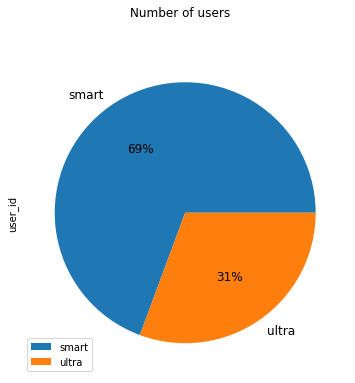

In [54]:
df.pivot_table(index='tariff', values='user_id', aggfunc = 'count')\
.plot(kind='pie', subplots = True, fontsize=12, figsize= (6,6), title = 'Number of users',\
     autopct =lambda p: '{:.0f}%'.format(p))
plt.show()

As you can see on the histogram, there are more than 2 times more Smart tariff users than Ultra tariff users.

For convenience, we distinguish two groups of users depending on the tariff they use.

In [55]:
df_smart = df.query('tariff == "smart"')
df_ultra = df.query('tariff == "ultra"')

### Call duration depending on the tariff

In [56]:
#look at the description and variance for the Smart tariff
display(df_smart['call_duration'].describe())
print('The dispersion is:', np.var(df_smart['call_duration']).round())

count    2229.000000
mean      393.929565
std       179.969846
min         0.000000
25%       267.000000
50%       397.000000
75%       515.000000
max      1354.000000
Name: call_duration, dtype: float64

The dispersion is: 32375.0


As you can see, the median and mean are almost the same, but the standard deviation is high, which indicates a large scatter in the data.

In [57]:
#look at the description for the Ultra tariff
display(df_ultra['call_duration'].describe())
print('The dispersion is:', np.var(df_ultra['call_duration']).round())

count     985.000000
mean      496.588832
std       299.864584
min         0.000000
25%       267.000000
50%       488.000000
75%       711.000000
max      1578.000000
Name: call_duration, dtype: float64

The dispersion is: 89827.0


Everything is exactly the same as in the previous tariff: the median and mean are almost the same, and the standard deviation is even higher here.

For convenience, let's create a function to call histograms, because Next, we will build histograms for messages and Internet traffic.

In [58]:
def histograms(df_smart, df_ultra, name, bins, length):
    ax = (df_smart
          .plot(kind = 'hist',
                bins = bins,
                range = length,
                alpha = 0.7,
                grid = True,
                density = True,
                legend = True,
                linewidth = 3,
                figsize=(12,6),
                label = 'smart')
         )
    (df_ultra
     .plot(kind = 'hist',
           ax = ax,
           bins = bins,
           range = length,
           alpha = 0.6,
           grid = True,
           density = True,
           legend = True,
           linewidth = 3,
           figsize=(12,6),
           label = 'ultra')
    )

    ax.set_title(name, fontsize=12)
    ax.set_xlabel(name, fontsize=12)
    ax.set_ylabel('Value Frequency', fontsize=12)
    plt.show()

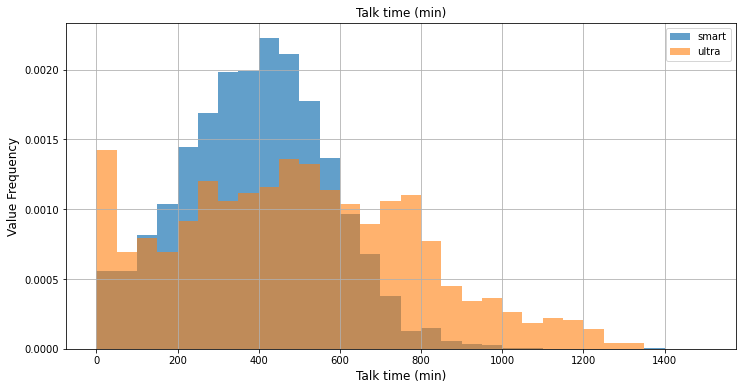

In [59]:
histograms(df_smart['call_duration'], df_ultra['call_duration'], 'Talk time (min)', bins = 30, length = (0, 1500))

Most Smart subscribers are within their 500 minute limit and only a few pay for additional minutes. Most speak for 400 to 500 minutes per month, which is just within the mean and median values.<br>
The histogram shows that the Ultra tariff has a more even distribution.<br>
On the Ultra tariff, subscribers talk more, but no one uses their limit of 3000 minutes in full. At the same time, it is clear that the Ultra tariff has significantly more calls up to 200 minutes per month than the Smart tariff.

Let's look at the share of subscribers exceeding the limits per month by minutes.

In [60]:
print('Exceeding the limit by minutes on the Smart tariff:',
      (df_smart.query('call_duration > 500')['call_duration'].count()
      /len(df_smart)).round(2))
print('Exceeding the limit by minutes on the Ultra tariff:',
      (df_ultra.query('call_duration > 3000')['call_duration'].count()
      /len(df_ultra)).round(2))

Exceeding the limit by minutes on the Smart tariff: 0.28
Exceeding the limit by minutes on the Ultra tariff: 0.0


34% of Smart tariff subscribers exceed their monthly limit by minutes.

### Number of messages depending on the tariff

In [61]:
#look at the description for the Smart tariff
display(df_smart['total_messages'].describe())
print('The dispersion is:', np.var(df_smart['total_messages']).round())

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: total_messages, dtype: float64

The dispersion is: 796.0


In [62]:
#look at the description for the Ultra tariff
display(df_ultra['total_messages'].describe())
print('The dispersion is:', np.var(df_ultra['total_messages']).round())

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: total_messages, dtype: float64

The dispersion is: 2283.0


For both rates, the mean is greater than the median. The standard deviation of the Ultra fare is significantly larger than that of the Smart fare, indicating a larger spread.<br>
But in general, based on the description, we can conclude that SMS is practically not used anymore.

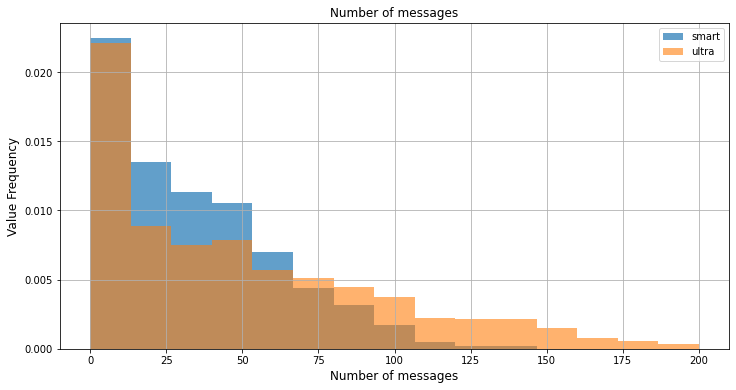

In [63]:
#build a histogram
histograms(df_smart['total_messages'], df_ultra['total_messages'], 'Number of messages', bins = 15, length = (0, 200))

Most of the values are in the range from 0 to 15 values, which most likely means correspondence with banks, yes NPS surveys. The remaining subscribers use an average of up to 75 messages per month.<br>
On the Ultra plan, SMS is used more often, but no one even comes close to the 1000 message limit.<br>
But on the Smart tariff, a considerable number of users exceed their limit of 50 SMS.

Let's look at the number of subscribers exceeding the limits per month reported.

In [64]:
print('Exceeding the limit on messages on the Smart tariff:',
      (df_smart.query('total_messages > 50')['total_messages'].count()
      /len(df_smart)).round(2))
print('Exceeding the limit on messages on the Ultra tariff:',
      (df_ultra.query('total_messages > 1000')['total_messages'].count()
      /len(df_ultra)).round(2))

Exceeding the limit on messages on the Smart tariff: 0.25
Exceeding the limit on messages on the Ultra tariff: 0.0


On the Smart tariff, 25% of subscribers exceed the limit by messages, which is lower than the number of those exceeding the limit by minutes.

### Internet traffic consumption depending on the tariff

In [65]:
#look at the description for the Smart tariff
display(df_smart['gb_used'].describe())
print('The dispersion is:', np.var(df_smart['gb_used']).round())

count    2229.000000
mean       15.828503
std         5.732887
min         0.000000
25%        12.346689
50%        16.119961
75%        19.573174
max        37.648877
Name: gb_used, dtype: float64

The dispersion is: 33.0


In [66]:
#look at the description for the Ultra tariff
display(df_ultra['gb_used'].describe())
print('The dispersion is:', np.var(df_ultra['gb_used']).round())

count    985.000000
mean      19.012505
std        9.850753
min        0.000000
25%       11.494395
50%       18.855479
75%       26.208682
max       48.579775
Name: gb_used, dtype: float64

The dispersion is: 97.0


As can be seen from the description, on the Smart tariff, the average and median are higher than the monthly traffic limit, i.e. more than 50% of subscribers purchase additional traffic.<br>
At the Ultra tariff, the average and median are within the limit, and approximately 15% of subscribers purchase additional traffic.<br>
The average for both tariffs is close to the median. The standard deviation on the Ultra tariff is almost twice as high as on Smart, which indicates a wider spread of data.

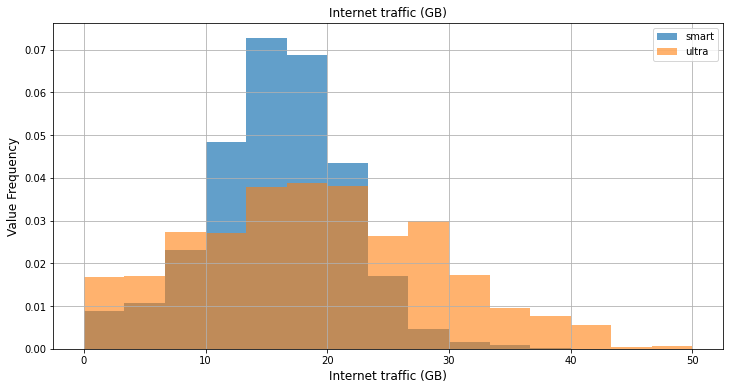

In [67]:
#build a histogram
histograms(df_smart['gb_used'], df_ultra['gb_used'], 'Internet traffic (GB)', bins = 15, length = (0, 50))

On both tariffs, most subscribers use traffic from 13 to 20 GB. Users of the Ultra tariff here also often get out of the limit, unlike minutes and messages. The distribution of data on the Ultra tariff is more even.

Let's look at the number of subscribers exceeding the Internet traffic limits.

In [68]:
print('Exceeding the Internet traffic limit on the Smart tariff:',
      (df_smart.query('gb_used > 15')['gb_used'].count()
      /len(df_smart)).round(2))
print('Exceeding the Internet traffic limit on the Ultra tariff:',
      (df_ultra.query('gb_used > 30')['gb_used'].count()
      /len(df_ultra)).round(2))

Exceeding the Internet traffic limit on the Smart tariff: 0.59
Exceeding the Internet traffic limit on the Ultra tariff: 0.14


From these data, we can conclude that the majority of Smart tariff subscribers do not have enough Internet traffic included in the tariff.

### Price and overpayment

In [69]:
#look at the description for the Smart tariff
display(df_smart['monthly_income'].describe())
print('The dispersion is:', np.var(df_smart['monthly_income']).round())

count    2229.000000
mean     1197.218927
std       767.412027
min       550.000000
25%       550.000000
50%       925.582031
75%      1602.906250
max      6540.775391
Name: monthly_income, dtype: float64

The dispersion is: 588657.0


In [70]:
#find a quantile with a border of 1950 rubles at the Smart tariff
df_smart['monthly_income'].quantile(0.8)

1798.4378906250001

In [71]:
#look at the description for the Ultra tariff
display(df_ultra['monthly_income'].describe())
print('The dispersion is:', np.var(df_ultra['monthly_income']).round())

count     985.000000
mean     2059.868918
std       354.880790
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4736.966309
Name: monthly_income, dtype: float64

Дисперсия составляет: 125813.0


There is a very interesting situation with the Smart tariff: a significant part of users pay much more for the tariff than the monthly fee of 550 rubles. The average is at the level of 1294 rubles, and the median is at the level of 1038 rubles. 20% of Smart tariff subscribers can switch to Ultra tariff, because they pay the same or even more. This became clear because in the 80th quintile, the monthly payment of users of the Smart tariff is 1950 rubles.<br>
At the Ultra tariff, the situation is opposite - most subscribers spend packages within the tariff.

Let's build a histogram with the ratio of revenue between tariffs.

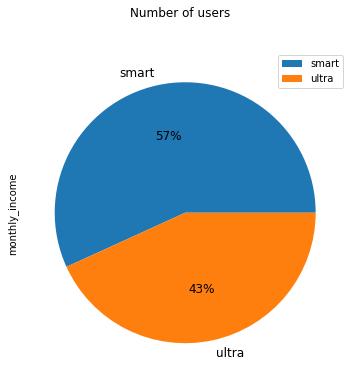

In [72]:
df.pivot_table(index='tariff', values='monthly_income', aggfunc = 'sum')\
.plot(kind='pie', subplots = True, fontsize=12, figsize= (6,6), title = 'Number of users',\
     autopct =lambda p: '{:.0f}%'.format(p))
plt.show()

Smart users brought in 18% more revenue than Ultra users, but their number is 2 times more, that is, the Smart tariff is cheaper for users.

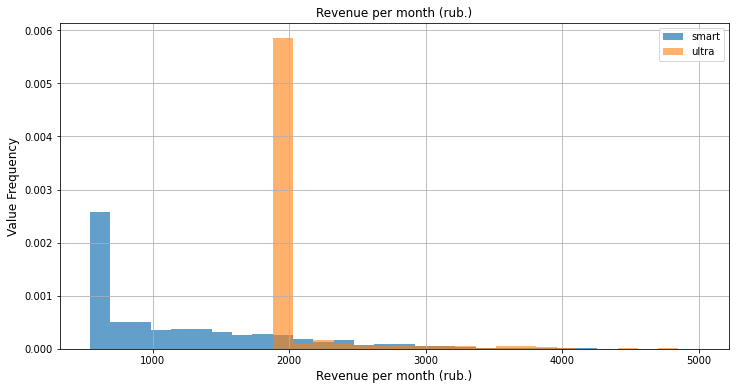

In [73]:
#build a histogram
histograms(df_smart['monthly_income'], df_ultra['monthly_income'], 'Revenue per month (rub.)', bins = 30, length = (540, 5000))

In [74]:
print('Overpayment in excess of the monthly fee on the Smart tariff:',
      (df_smart.query('monthly_income > 550')['monthly_income'].count()
      /len(df_smart)).round(2))
print('Overpayment in excess of the subscription fee on the Ultra tariff:',
      (df_ultra.query('monthly_income > 1950')['monthly_income'].count()
      /len(df_ultra)).round(2))

Overpayment in excess of the monthly fee on the Smart tariff: 0.73
Overpayment in excess of the subscription fee on the Ultra tariff: 0.14


The histogram shows everything the same as it was in the description - 75% of Smart tariff users very often overpay in excess of the monthly fee, in contrast to the Ultra tariff, where the vast majority of users fit into package limits and monthly fees.

### Section Conclusion

<font size = 3><b>Based on the analysis of the data, the following conclusions can be drawn:</b></font>
1. The number of users on the Smart tariff exceeds the number of users on the Ultra tariff by more than 2 times.
2. In terms of the number of minutes and messages on the Smart tariff, most users fit into the tariff limits, but 59% of users purchase additional Internet traffic.
3. Ultra tariff users do not use the entire package of minutes and messages, and only 14% of users do not fit into the Internet traffic limit.
4. As many as 75% of users overpay in excess of the monthly fee on the Smart tariff, while only 14 users of the Ultra tariff pay in excess of the monthly fee (exactly 14% of users who exceed the limit on Internet traffic).
5. Approximately 20% of Smart tariff subscribers can switch to the Ultra tariff painlessly, because they pay 1950 rubles or more per month.
6. Already now we can say that the Ultra tariff is more profitable for the operator, because its users pay an average of 2071 rubles per month, and users of the Smart tariff pay an average of 1294 rubles per month. At the same time, users of the Ultra tariff do not use all communication packages provided by the operator, which also brings additional benefits to the mobile operator.
<br>
<br>

## Hypothesis testing

In this section, we will test 2 hypotheses:
1. That the average revenue of Ultra and Smart users is different;
2. The average revenue of users from Moscow differs from the revenue of users from other regions.

### Hypothesis 1: The average revenue from users of Ultra and Smart tariffs is different

Let's compare the average revenue in Smart and Ultra tariffs. We formulate the null and alternative hypotheses.<br>
<b>Null hypothesis (H0):</b> сthe average revenue for Smart and Ultra tariffs does not differ.<br>
    <b>Alternative hypothesis (H1):</b> the average revenue for Smart and Ultra tariffs is different. The alternative hypothesis is two-sided - it does not matter to us in which direction the deviation will be, the very fact of the presence of the deviation is important, i.e. the fact that the average revenue for tariffs is not equal.

Let's test the hypothesis about the equality of the average values of revenue.

In [75]:
print('Average revenue under the Smart tariff:', df_smart['monthly_income'].mean())
print('Average revenue under the Ultra tariff:', df_ultra['monthly_income'].mean())

Average revenue under the Smart tariff: 1197.218926999215
Average revenue under the Ultra tariff: 2059.8689175523477


As you can see, the difference in average revenue is already more than 30%, so we specify the `equal_var=False` parameter.

Set the significance level (alpha) to 0.05.
Because we test the hypothesis about the equality of the mean of two populations by samples, we apply the scipy.stats.ttest_ind method

In [76]:
smart_mean = df_smart['monthly_income']
ultra_mean = df_ultra['monthly_income']

alpha = 0.05 
results = st.ttest_ind(
    smart_mean,
    ultra_mean,
    equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value: 0.0
Rejecting the null hypothesis


The null hypothesis is rejected, which means we accept as true the alternative hypothesis that the average revenue for the Smart and Ultra tariffs is different.

<b>So, our main hypothesis is confirmed and the average revenue of users of the Ultra and Smart tariffs differs.</b>

### Hypothesis 2: The average revenue of users from Moscow differs from the revenue of users from other regions

<b>Null hypothesis (H0):</b> The average revenue of users from Moscow does not differ from the revenue of users from other regions.<br>
<b>Alternative hypothesis (H1):</b> The average revenue of users from Moscow differs from the revenue of users from other regions.

In [77]:
#filter the dataset by city
moscow = df.query('city == "Москва"')
others = df.query('city != "Москва"')

In [78]:
#look at the averages of these samples
print ('Moscow average:', moscow['monthly_income'].mean())
print ('Average values for other cities:', others['monthly_income'].mean())

Moscow average: 1484.8365688292758
Average values for other cities: 1456.1416552115347


The difference between the two averages is only 1.5%, so we use the `equal_var=True` parameter

Set the significance level (alpha) to 0.05.
Because we test the hypothesis about the equality of the mean of two populations by samples, we apply the scipy.stats.ttest_ind method

In [79]:
moscow_mean = moscow['monthly_income']
others_mean = others['monthly_income']

alpha = 0.05 
results = st.ttest_ind(
    moscow_mean,
    others_mean,
    equal_var=True)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value: 0.4119903138820259
Failed to reject the null hypothesis


As you can see, the null hypothesis could not be rejected and the revenue from users from Moscow does not differ from the revenue from users from other cities.

<b>Our main hypothesis is rejected and the average revenue of users from Moscow does not differ from the revenue of users from other regions.</b>

### Section Conclusion

Based on the statistical analysis, we came to the following conclusions:
1. Hypothesis 1 was confirmed and the average <b>revenue from users of the "Ultra" and "Smart" tariffs differs.</b>
2. Hypothesis 2 is refuted and the average <b>revenue of users from Moscow does not differ from the revenue of users from other regions.</b>

## General conclusion

Clients are offered two tariff plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department wants to understand which tariff brings in more money. We had to make a preliminary analysis of tariffs on a small sample of customers. We have at our disposal the data of 500 Megaline users: who they are, where they are from, what tariff they use, how many calls and messages each sent in 2018. It was necessary to analyze the behavior of customers and draw a conclusion - which tariff is better.
1. <b>5 datasets were presented and studied:</b> with calls, messages, Internet traffic, tariffs and users.
2. <b>These datasets were pre-processed:</b>
    - brought data in date columns to datetime type;
    - added month columns to datasets with calls, messages and internet sessions;
    - rounded up the data in the columns with minutes and Internet traffic;
    - converted MB to GB;
    - grouped the data and combined them into a new dataset;
    - removed columns from the new dataset that will not be used in further analysis;
3. <b>Prepared data for analysis:</b>
     - calculated in the summary table by month:
         1. number of calls made and spent minutes of conversation;
         2. the number of sent messages;
         3. the amount of Internet traffic used;
     - calculated the monthly revenue from each user.
4. <b>During the exploratory data analysis, the following conclusions were made:</b>
    1. The number of users on the Smart tariff exceeds the number of users on the Ultra tariff by more than 2 times.
    2. In terms of the number of minutes and messages on the Smart tariff, most users fit into the tariff limits, but 59% of users purchase additional Internet traffic.
    3. Ultra tariff users do not use the entire package of minutes and messages, and only 14% of users do not fit into the Internet traffic limit.
    4. Already 75% of users overpay in excess of the monthly fee on the Smart tariff, while only 14 Ultra tariff users pay in excess of the monthly fee (exactly 14% of users who exceed the limit on Internet traffic).
    5. Approximately 20% of Smart tariff subscribers can switch to the Ultra tariff painlessly, because they pay 1950 rubles or more per month.
    6. Already now we can say that the Ultra tariff is more profitable for the operator, because its users pay an average of 2071 rubles per month, and users of the Smart tariff pay an average of 1294 rubles per month. At the same time, users of the Ultra tariff do not use all communication packages provided by the operator, which also brings additional benefits to the mobile operator.
5. <b>Based on the statistical analysis of the data, we came to the following conclusions:</b>
    1. Hypothesis 1 was confirmed and the average revenue from users of the Ultra and Smart tariffs differs. Ultra tariff users pay 38% more monthly than Smart tariff users.
    2. Hypothesis 2 is refuted and the average revenue of users from Moscow does not differ from the revenue of users from other regions.